In [1]:
import numpy as np
from math import factorial
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import brentq
from scipy import stats
from functools import partial
import matplotlib.pyplot as plt

## Generate data

In [2]:
N=10
s_true = 2 #0.1 #2.
b_true = 8.
np.random.seed(123) #39#32# 123
fs = np.random.rand(N)
fb = np.random.rand(N)
lamb_true = fs * s_true + fb * b_true  
data = np.random.poisson(lamb_true)

In [3]:
print('data=',data)
print(' ')
print('lamb_true =',lamb_true)
print(' ')
print('s = ',fs * s_true)
print(' ')
print('b = ',fb*b_true)

data= [7 5 6 0 6 7 8 2 5 4]
 
lamb_true = [4.1383625  6.40467633 3.96228086 1.58005271 4.62329198 6.75017617
 3.42146224 2.77327353 5.21427479 5.03885573]
 
s =  [1.39293837 0.57227867 0.45370291 1.10262954 1.43893794 0.84621292
 1.9615284  1.36965948 0.9618638  0.78423504]
 
b =  [2.74542413 5.83239766 3.50857796 0.47742317 3.18435404 5.90396325
 1.45993384 1.40361405 4.25241099 4.2546207 ]


## Compute the negative log-likelihood

In [4]:
def Bdist(b,i):
    # probability of getting background = b at bin i
    #return (1/(b_true*fb[i]))*np.exp(-b/(b_true*fb[i])) # this is the exponential distribution
    sigma=1.0
    return stats.norm.pdf(b,b_true*fb[i],sigma)

In [5]:
def logBdist(b,i):
    return np.log(1/(b_true*fb[i])) - b/(b_true*fb[i])

In [6]:
def Pois(n,lam):
    return np.exp(-lam)*lam**n/factorial(n)

In [7]:
def logfact(n):
    # this is an approximation to Log(n!) (except for when n=0)                                                                                                        
    if(n!=0):
        lnF = n*np.log(n) - n + (np.log(n*(1+4*n*(1+2*n))))/6 + np.log(np.pi)/2
    else:
        lnF = 0
    return lnF

In [8]:
def logPois(n,lam):
    return -lam + n*np.log(lam) - logfact(n)
        

In [9]:
def nlogL(params):
    s=params[0]
    b=params[1]
    logL_arr = []
    for i in range(len(data)):#:range(len(data)):
        logL_arr.append(np.log(Pois(data[i],fs[i]*s + fb[i]*b)) + np.log(Bdist(b*fb[i],i)))
        #logL_arr.append( logBdist(fb[i]*b,i) +logPois(data[i],fs[i]*s + fb[i]*b))
    return -np.sum(logL_arr)

In [10]:
nlogL([s_true,b_true])

30.70760314453405

## Getting the optimum parameters

In [11]:
params_opt,fmin,etc=fmin_l_bfgs_b(nlogL, [1.,1.], approx_grad=True, iprint=101, bounds=[(0,100),(0,100)])

In [12]:
fmin

29.98544368146277

In [13]:
nlogL_min = fmin

In [14]:
params_opt

array([3.29026621, 7.95673245])

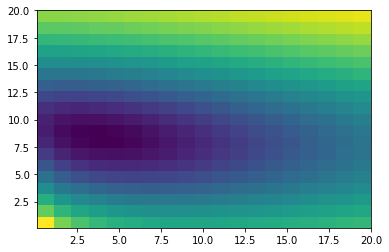

In [15]:
def nlogL_A(b,s):
    logL_arr = []
    for i in range(len(data)):
        logL_arr.append(np.log(Pois(data[i],fs[i]*s + fb[i]*b)) +np.log(Bdist(b*fb[i],i)) )
        #logL_arr.append(logPois(data[i],fs[i]*s + fb[i]*b) + logBdist(fb[i]*b,i))
    return -np.sum(logL_arr,axis=0)

b_arr=np.linspace(0.1,20,20)
s_arr=np.linspace(0.1,20,20)
X,Y = np.meshgrid(s_arr, b_arr)
Z=nlogL_A(Y,X)

plt.pcolor(X,Y,np.log(Z))
plt.show()

## Profiling over background

In [16]:
def prof_nlogL(signal):
    nlogL_b = partial(nlogL_A,s=signal)
    bopt, fmin, etc =  fmin_l_bfgs_b(nlogL_b, 1., approx_grad=True, bounds=[(0,100)])
    return nlogL_A(bopt[0],signal)

In [17]:
prof_nlogL(2.)

30.66837412378391

## Likelihood ratio and confidence interval

In [18]:
def LR(signal):
    return 2*(prof_nlogL(signal) - nlogL_min)

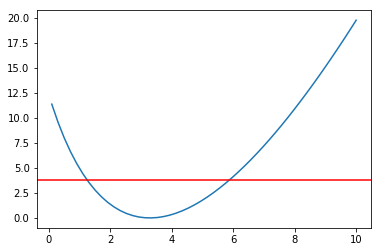

In [27]:
s_arr=np.linspace(0.1,10,50)
LR_arr=[]
for s in s_arr:
    LR_arr.append(LR(s))

plt.plot(s_arr, LR_arr)
# note below that alpha=0.05 and beta=0.05, such that 1-alpha-beta=0.9 => 90%CL
plt.axhline(y=3.841,color='red') # critical value at the right of the distrib, for 90%CL
#plt.axhline(y=0.004,color='red') # critical value at the left of the distrib, for 90%CL
#plt.yscale('log')
plt.show()

In [20]:
print(s_arr[np.argmin(LR_arr)])

3.33265306122449


In [21]:
#getting upper limit
def LR_up(signal):
    return 2*(prof_nlogL(signal) - nlogL_min) - 3.84

signal_up = brentq(LR_up,2,8)
print(signal_up)

5.89465953161732


In [22]:
#getting lower limit
def LR_lo(signal):
    return 2*(prof_nlogL(signal) - nlogL_min) - 3.84

signal_lo = brentq(LR_lo,0.1,3.35)
print(signal_lo)

1.2380335423513489


In [23]:
print('optimum is:',round(params_opt[0],4),
      ', conf. interval @90%CL is: [',round(signal_lo,4),',',round(signal_up,4),']')

optimum is: 3.2903 , conf. interval @90%CL is: [ 1.238 , 5.8947 ]
